# Data and model testing

In [ ]:
import os

# gets rid of irritating warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Data preprocessing and initial quality checking

We will be using [booking.com reviews dataset](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe?resource=download), with over 500 thousand reviews of hotels. They are either positive or negative, and we will focus on review sentiment. We have [hosted it on HuggingFace](https://huggingface.co/datasets/morgul10/booking_reviews), with just the relevant columns.

We will start with loading the data and initial checks - a **smoke test** of the data. Aim is to understand our dataset, and to detect obvious and serious problems. It is always a necessary process in ML.

Most basic checks, which should always be performed, are:
- data length
- column types
- example rows
- exact duplicates check
- labels distributions (for supervised problems)
- more specific checks depending on the modality, e.g. text lengths distribution in NLP

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from datasets import load_dataset


df_raw = load_dataset("morgul10/booking_reviews")["train"].to_pandas()
df_neg = df_raw["Negative_Review"].str.strip()
df_pos = df_raw["Positive_Review"].str.strip()

In [ ]:
print("Total data length:", len(df_raw))
print("Negative reviews:", len(df_neg))
print("Positive reviews:", len(df_pos))

In [ ]:
print("Data types:")
display(df_raw.dtypes)

In [ ]:
print("First rows:")
display(df_raw.head(10))

In [ ]:
print("Last rows:")
display(df_raw.tail(10))

In [ ]:
df_neg.str.len().plot.hist(title="Negative reviews lengths")

In [ ]:
df_pos.str.len().plot.hist(title="Positive reviews lengths")

As you can see, the data contains quite a few "No Negatives" and "No Positive" rows. This is a widespread problem with "empty" rows, which are not really empty. They can take a form of:
- default text, like we have here (frequent in automated forms, data from web scraping etc.)
- empty string instead of NULL
- deleted rows, but only marked with "deleted" column (frequent in data warehouses)

Those problems can also crop up during inference (e.g., empty text), and should be handled properly.

This is a particular instance of **duplicate data** problem, which is surprisingly common. Another reason may be that people writing texts don't care, e.g. input generic answers like "ok" or "everything". This biases the model, essentially putting more weights on those texts. Worse, they can have different labels, which introduces strong noise.

Let's see how frequent is this problem.

### Exercise 1 (1 point)

Check the percentage of 20 most common text duplicates. This can be achieved with Pandas code conceptually similar to a combination of GROUP BY and COUNT aggregation. Check it:
- in positive and negative subsets
- for the whole dataset

### Manual data cleaning

Imagine training (and testing!) a model on data, where about 25% of negative class is duplicated, or has useless values like "none". Not a good idea, so we will remove those duplicates simply by using a case-insensitive regular expression. We will also remove words like "breakfast" or "location," which do not discriminate at all between positive and negative sentiment.

In [ ]:
to_remove = [
    "No Negative", "No Positive", "nothing", "nothing really", "none", "n a", "na",
    "everything", "location", "the location", "breakfast", "the breakfast", "staff",
]
to_remove = [f"^{word}$" for word in to_remove]
to_remove = "|".join(to_remove)
to_remove

We will also perform two common cleaning steps: deduplication and removing empty strings. We can safely assume that people are lazy and write short, generic reviews, so there will be quite a few duplicates even after removing the most obvious cases.

In [ ]:
df_neg_filtered = df_neg[~df_neg.str.contains(to_remove, case=False, na=True, regex=True)]
df_pos_filtered = df_pos[~df_pos.str.contains(to_remove, case=False, na=True, regex=True)]

# empty strings removal
df_neg_filtered = df_neg_filtered[df_neg_filtered.str.len() > 0]
df_pos_filtered = df_pos_filtered[df_pos_filtered.str.len() > 0]

df_neg_filtered = df_neg_filtered.reset_index(drop=True)
df_pos_filtered = df_pos_filtered.reset_index(drop=True)

df_neg_filtered = df_neg_filtered.to_frame().rename(columns={"Negative_Review": "text"})
df_pos_filtered = df_pos_filtered.to_frame().rename(columns={"Positive_Review": "text"})

df_neg_filtered["label"] = 0
df_pos_filtered["label"] = 1

print("Negative samples after filtering:", len(df_neg_filtered))
print("Positive samples after filtering:", len(df_pos_filtered))

df_all = pd.concat([df_neg_filtered, df_pos_filtered], ignore_index=True)
df_all = df_all.drop_duplicates(ignore_index=True)

Lastly, we have quite a lot of data, so we'll randomly subsample it. We will use stratification, so that the label distribution will be the same after sampling.

**Modify this** depending on your hardware. Very good GPU should handle up to ~100k samples, medium-grade GPU about ~10-50k, and CPU about 5k. The more samples you process, the better the results will be.

In [ ]:
from sklearn.utils import resample


df = resample(df_all, replace=False, n_samples=5000, random_state=0, stratify=df_all["label"])
df = df.reset_index(drop=True)
df

## CleanLab blackbox testing

[CleanLab library](https://github.com/cleanlab/cleanlab) aims to provide a blackbox, dead simple to use solution to ensure data quality. It can clean both data and labels, and works for any models. It is based on the framework of **confident learning (CL)**, originally created for detecting problems with data annotations.

The main idea is as follows. A reasonably good model trained on the data should be very confident about properly annotated texts, and uncertain about ambiguous or incorrectly annotated texts. This is measured by predicted class probabilities. There are, of course, more details (e.g., class-conditioning, distinguishing model and data errors), but the general idea is really simple, and works with any data modality. It can not only detect errors, but also fix them. If another label is predicted with very high confidence, there is a high chance it's the correct one.

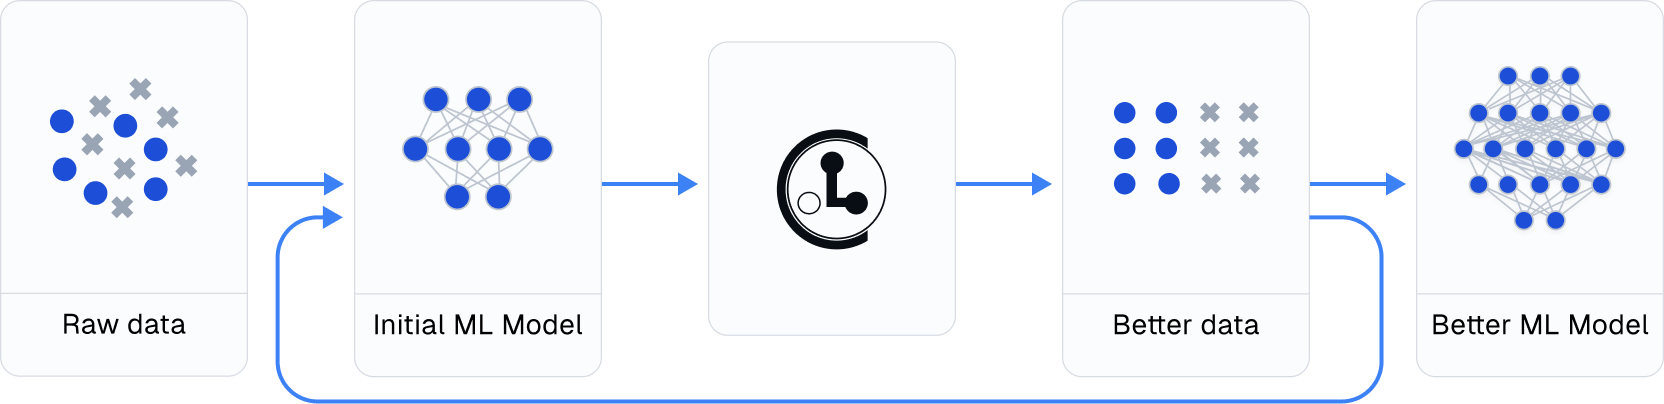

Researchers in confidence learning, and creators of CleanLab, used this methodology in paper ["Pervasive label errors in test sets destabilize machine learning benchmarks" C.G. Northcutt et al](https://arxiv.org/abs/2103.14749). They showed that in popular text and image benchmarking datasets, up to 10% of labels are incorrect.

We will take a similar approach to test our dataset. To avoid a chicken-and-egg problem (we don't have a model yet, but we need model probabilities), we need the **initial model**. A simple, yet effective approach is using a pretrained embedding model, combined with a linear classifier. This method is equivalent to freezing weights and training just the classifier head. Both embeddings and probability predictions are then used by CleanLab to detect problems.

For text classification, the workflow recommended by [HuggingFace Open-Source AI Cookbook](https://huggingface.co/learn/cookbook/en/issues_in_text_dataset) is:
1. Compute text embeddings with a pretrained Sentence Transformer for feature extraction
2. Train logistic regression with cross-validation
3. Gather predicted probabilities (model confidence scores) for validation sets
4. Use CleanLab using this data

Bonus: we originally detected some problems with duplicates in this dataset also by using CleanLab.

### Exercise 2 (1 point)

Implement the `get_initial_model_data()` function:
1. Compute text embeddings with [sentence-transformers](https://sbert.net/docs/sentence_transformer/pretrained_models.html) and `all-MiniLM-L6-v2` model.
2. Create `LogisticRegression` object
3. Train logistic regression and get probability predictions using `cross_val_predict()`. Note that it requires explicitly specifying that `predict_proba()` method should be used, in order to return probabilities, rather than 0/1 labels.


In [ ]:
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict


def get_initial_model_data(texts: np.ndarray, labels: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    ...

    return embeddings, pred_probs


#### Verification

In [ ]:
texts = df["text"].values
labels = df["label"].values

embeddings, pred_probs = get_initial_model_data(texts, labels)

And now, we can use the CleanLab with the obtained embeddings and probability predictions.

In [ ]:
from cleanlab import Datalab


data_dict = {"texts": texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels", task="classification")
lab.find_issues(pred_probs=pred_probs, features=embeddings)
lab.report()

About 1.9% of duplicates, even after our cleaning, are quite expected. Many people don't really care and write short, generic reviews. Still, the data-driven approach confirms it, and we'll take a closer look at this. Additionally, about 2.2% of mislabeled data looks quite problematic.

To programmatically inspect a given issue, `.get_issues()` method is used. For a given issue type (see report above for exact names), it returns a DataFrame with score for each sample. Lower score means higher risk of problems. It also returns a column with a boolean indicator whether a given sample has the problem, e.g. `is_near_duplicate_issue` or `is_label_issue`, which uses a default threshold for the score.

Let's inspect the duplicate issues for now.

In [ ]:
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")

Row index indicates the row with a problem, and `near_duplicate_sets` are indices of duplicate rows. `distance_to_nearest_neighbor` measures distance between embeddings. Let's see the top 10 cases with most obvious duplicates.

In [ ]:
for idx, row in duplicate_issues.head(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print(f"Text: {text}")
    print(f"\tDuplicates: {neighbors}")
    print()

Yeah, we forgot that `Pandas` is case-sensitive about finding duplicates. So with CleanLab, we identified a problem with our preprocessing. We will filter this in just a bit. Let's also see the last 10 duplicates.

In [ ]:
for idx, row in duplicate_issues.tail(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print(f"Text: {text}")
    print(f"\tDuplicates: {neighbors}")
    print()

Definitely similar, but not exactly duplicates. We will remove the case-insensitive duplicates now. Note that we will keep the index to avoid recalculation for inspecting further issues.

In [ ]:
df["text_lower"] = df["text"].str.lower()
df_deduplicated = df.drop_duplicates(subset="text_lower")
df_deduplicated = df_deduplicated.drop(columns="text_lower")
df_deduplicated

Now we will inspect labels. If our model predicts the label different from the real one with very high confidence, it may be a mislabeled sample.

In [ ]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]
label_issues = label_issues.sort_values(by="label_score")

top_label_issues_y_true = label_issues.head(10)["given_label"]
top_label_issues_y_pred = label_issues.head(10)["predicted_label"]
top_label_issues_idxs = label_issues.head(10).index
top_label_issues_texts = texts[top_label_issues_idxs]

print("Top 10 label issues")
for text, y_true, y_pred in zip(top_label_issues_texts, top_label_issues_y_true, top_label_issues_y_pred):
    print(f"y_true {y_true}, y_pred {y_pred}, text: {text}")
    print()

The reason for those is most probably that on booking.com there are separate fields for positive and negative reviews. Some people may get confused and put texts in the wrong place. So we also identified a potential UX issue, in addition to the labeling problem.

We will change the labels as suggested by CleanLab.

In [ ]:
# make sure we don't get key errors - we removed some rows earlier during deduplication
label_issues = label_issues[label_issues.index.isin(df_deduplicated.index)]

idxs = label_issues.index.tolist()
pred_labels = label_issues["predicted_label"]

df_fixed = df_deduplicated.copy()
df_fixed.loc[idxs, "label"] = pred_labels
df_fixed

### Exercise 3 (1 point)

1. Print texts from the rows marked as outliers (`outlier` problem) with the strongest confidence (i.e., the lowest score).
2. Comment, do you think those samples really are strange? Would you remove them?

// comment here

# Model Quality Testing
This stage is essential for assessing the robustness, reliability, and performance of AI models developed using the curated data. Model Quality Testing enables us to verify that the model meets the intended goals and performs well across various scenarios and data subsets. This not only scrutinizes the accuracy and efficiency of models but also ensures that they are fair, accountable, and transparent in their operations.

## Common metrics

Now that our data is cleaned and prepared, we can train a model and proceed to test it. Firstly, we will just look at common numerical metrics, summarizing the model performance over test data. Further, we will perform **behavioral testing**, checking its stability, biases and other problems not visible when just using typical performance metrics on labels.

Firstly, we will focus on just regular metrics, which use predicted probabilities and labels. Our dataset is relatively balanced, which is quite rarely the case. In any case, metrics that take label imbalance into consideration are a good choice. Well-known ones are:
1. Precision: if the model predicts the positive class, precision measures how sure we can be that it's really the positive class. High precision means low fraction of false positives (FP).
2. Recall: measures how much of the positive class the model detected. High recall means low fraction of false negatives (FN).
3. F1-score: a harmonic mean of precision and recall, aggregates them into one number for convenience. Harmonic mean heavily penalizes small numbers, so to get high value, both precision and recall have to be high, not just one of those.

Area Under Receiver Operating Characteristic (AUROC / ROC AUC) is less frequently used in NLP, but has a few beneficial properties. It takes into consideration model probability predictions. For different thresholds (percentage above which we assume positive class) we measure the fractions of true positives and false positives, and aggregate those numbers. To achieve high AUROC, the model has to predict the right class with high probability, and avoid false positives even for low thresholds.

Matthews Correlation Coefficient (MCC) can be thought of as Pearson correlation, but for binary variables. It has favorable statistical properties, and can spot model failures even when accuracy or AUROC are high. In particular, high MCC guarantees high AUROC and typically also other metrics, but not the other way around. For details, see:
- [Wikipedia summary](https://en.wikipedia.org/wiki/Phi_coefficient#Advantages_over_accuracy_and_F1_score)
- ["Ten quick tips for machine learning in computational biology" D. Chicco](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5721660/)
- ["The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation" D. Chicco, G. Jurman](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6941312/)
- ["The Matthews correlation coefficient (MCC) should replace the ROC AUC as the standard metric for assessing binary classification" D. Chicco, G. Jurman](https://biodatamining.biomedcentral.com/articles/10.1186/s13040-023-00322-4)

Furthermore, any probabilistic metric like AUROC requires **well-calibrated** models, i.e. predicting probabilities right. Optimizing cross-entropy (log-loss) directly uses class probabilities, therefore logistic regression and neural networks typically are well-calibrated. Tree-based models, Naive Bayes or SVMs are often surprisingly bad at predicting probabilities. If a model is well-calibrated, we can trust that the probability it predicts is close to the true (typically unknown) probability.

### Training a classifier

We will fine-tune a simple [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased) model (uncased variant) for binary classification. This is a typical HuggingFace code for training. We will evaluate the resulting model on many metrics, to gain more insight into its performance. During training, we will measure MCC every 1000 steps, to check how the training is progressing.

In [ ]:
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split


# 60-10-30% split
test_size = int(0.3 * len(df_fixed))
train_size = int(0.6 * len(df_fixed))

df_train, df_test = train_test_split(df_fixed, test_size=test_size, random_state=0, stratify=df_fixed["label"])
df_train, df_valid = train_test_split(df_train, train_size=train_size, random_state=0, stratify=df_train["label"])

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_valid, split="valid")
datasets_dict["test"] = Dataset.from_pandas(df_test, split="test")

In [ ]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples


num_cores = joblib.cpu_count(only_physical_cores=True)
datasets_tokenized = datasets_dict.map(tokenize, batched=True)

In [ ]:
import os
import random

from sklearn.metrics import matthews_corrcoef
from torch.nn.functional import softmax
from transformers import AutoModelForSequenceClassification, EvalPrediction, Trainer, TrainingArguments


# set determinism settings
os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2)


# freeze some weights to speed up training
for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False

for param in model.distilbert.transformer.parameters():
    param.requires_grad = False


def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids.ravel()
    logits = torch.from_numpy(eval_pred.predictions)
    y_pred_proba = softmax(logits, dim=1)[:, 1].numpy()
    y_pred = (y_pred_proba >= 0.5).astype(int)
    mcc = matthews_corrcoef(y_true, y_pred)
    return {"MCC": mcc}


training_args = TrainingArguments(
    output_dir="finetuned_model",
    # change num_train_epochs depending on your hardware
    # if lower, increase learning rate and decrease save_steps and eval_steps
    learning_rate=1e-2,
    num_train_epochs=1,
    eval_strategy="steps",
    save_steps=50,
    eval_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    seed=0,
    data_seed=0,
    fp16=True,  # comment this out if you have unsupported hardware
    dataloader_num_workers=1,  # comment out if necessary
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

In [ ]:
from sklearn.metrics import f1_score, matthews_corrcoef, precision_score, recall_score, roc_auc_score


pred_output = trainer.predict(datasets_tokenized["test"])
logits = torch.from_numpy(pred_output.predictions)
y_pred_proba = softmax(logits, dim=1)[:, 1].numpy()
y_pred = (y_pred_proba >= 0.5).astype(int)
y_test = datasets_tokenized["test"]["label"]

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")
print(f"F1-score: {f1_score(y_test, y_pred):.2%}")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba):.2%}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.2%}")

Generally, we seem to have a quite good classifier, but a significantly lower MCC may indicate some problems. Although, we have to remember that these are just aggregate numbers, and may lead to wrong conclusions. Let's inspect some predictions manually.

The simplest way to check is to do something similar to CleanLab label check. We take the predicted probabilities and check the test instances where:
- the model predicted the lowest probability for the positive class, or the highest probability for the negative class
- where the model was the most uncertain, i.e., the probability was closest to 50%

### Exercise 4 (1 point)

From test data, select:
- Ten worst false positives (with the highest predicted probability, where the true class is negative)
- Ten worst false negatives (with the lowest predicted probability among the truly positive class)
- Ten most uncertain predictions (with probability closest to 50%)

Do you see any obvious problems here?

## Behavioral testing with Giskard

[Giskard](https://github.com/Giskard-AI/giskard) is a library for testing tabular, NLP, vision models, and LLMs. It can detect issues like over- and underconfidence, unfairness (sensitivity to gender, religion, etc.), bias towards certain words or segments, etc. There are easily usable integrations with scikit-learn, HuggingFace or LangChain.

It mostly relies on **slicing** and **input perturbation** techniques. Slicing analyzes model performance in slices (segments) e.g. when specific words appear. Input perturbations (also called transformations) slightly modify the input data and compare the model behavior between original and perturbed data. These can be introducing typos, lower- or uppercase, changing gender and religion words etc.

Giskard requires passing a prediction function, which takes raw test data and returns model predictions, as well as a few other configuration elements. Importantly, if we want interpretable perturbations, we need to pass raw texts as inputs, so that they can be modified. Therefore, the embedding calculation needs to be inside this prediction function. We also use the logistic classifier trained above.

**Warning:** this can take a bit. If it takes too long, you can subsample the test set to make it smaller.

In [ ]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan, testing
from transformers import pipeline

trained_model = trainer.model
trained_model.eval()
model_pipeline = pipeline(
    "text-classification", 
    model=trained_model, 
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu",
)


@torch.no_grad()
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    pred_output = model_pipeline(df["text"].tolist())
    y_pred_proba = [pred["score"] for pred in pred_output]
    return y_pred_proba


giskard_dataset = GiskardDataset(df_test, target="label")

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=[0, 1],
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

In [ ]:
display(scan_results)

We have only a few issues. Perfect. We have performance problems in some segments, containing words like "small" or "bathroom". Fixing such issues is often not straightforward, however, and generally requires more data, or data augmentation with e.g. [nlpaug](https://github.com/makcedward/nlpaug) library. Typically, fixing many of these issues is quite hard, but just being aware of them can be useful.

# Interpretability
Interpretability is a fundamental aspect of developing trustworthy and effective AI systems, particularly when decisions made by these systems have significant implications. It involves understanding and explaining how AI models make their decisions, which is crucial for gaining user trust, fulfilling regulatory requirements, and facilitating model debugging and improvement. It bridges the gap between advanced computational models and human understanding, ensuring that AI systems are not only powerful and efficient but also aligned with ethical standards and user expectations.

## Global vs local explainability

Understanding the overall behavior of the model is known as **global explainability**, and is generally tough. Modern NLP models are incredibly complex and basically impossible to summarize like "if description mentions small room, then predict negative sentiment". This is also less interesting to end users, who are often interested in understanding prediction for a single given text, known as **local interpretability**.

There are a lot of techniques for this, benchmarked in papers:
- ["A Diagnostic Study of Explainability Techniques for Text Classification" P. Atanasova et al.](https://aclanthology.org/2020.emnlp-main.263/)
- ["A Multilingual Perspective Towards the Evaluation of Attribution Methods in Natural Language Inference" K. Zaman, Y. Belinkov](https://aclanthology.org/2022.emnlp-main.101/)

Interestingly, both papers and our practical experience show that the simplest **gradient attribution** methods perform the best. They are fast, faithful to the inner workings of the model, and make sense for human evaluators. Concretely, InputXGradient method with either mean or L2 normalization per word gives the best results. In short, it works as follows:
1. Compute model prediction with gradients, just like during training, but without updating model weights.
2. With backpropagation, compute gradient for each input token, also known as saliency or **attribution**.
3. Multiply tokens by their gradient (hence the name), getting token attribution vector.
4. Normalize attribution, i.e., calculate either average or L2-normalized score for each word.

This way, we get a single number per token. Gradients are computed for a given class. For binary classification, we predict the probability of positive class. Therefore, higher scores indicate that tokens increase the probability, and negative scores mean that they decrease probability.

Why does this simple method work very well? We don't really know. There are some hypotheses, but they are of high mathematical complexity. If you're interested, see e.g. ["The Manifold Hypothesis for Gradient-Based Explanations" S. Bordt et al](https://openaccess.thecvf.com/content/CVPR2023W/XAI4CV/papers/Bordt_The_Manifold_Hypothesis_for_Gradient-Based_Explanations_CVPRW_2023_paper.pdf). A major advantage is also speed. This requires computing gradients, but it's still just one forward and backward pass through the model. Other methods are much more complex, like SHAP for text, which has almost exponential complexity.

## Local explainability with Captum

[Captum](https://captum.ai/) is the most popular model interpretability library for PyTorch. It works for computer vision, NLP, [LLMs](https://captum.ai/tutorials/Llama2_LLM_Attribution) and other models. While the most important part are model attributions, which we will use to understand inputs, Captum also supports adversarial attacks, neuron and layer explanations, and identifying influential examples.

The code below is modified from [Captum question answering tutorial](https://captum.ai/tutorials/Bert_SQUAD_Interpret). Firstly, we tokenize texts. The essential part is calling the `configure_interpretable_embedding_layer()` function - this special embedding layer replaces the existing transformer embedding layer with Captum one, which tracks gradients and combines explanations with original tokens. Furthermore, since Captum requires gradients, we need to make a small wrapper to pass `attention_mask` to our transformer. Lastly, we make the overall model prediction and use built-in visualization methods to plot the results.

In [ ]:
from copy import deepcopy

from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis


class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]


def explain_text(model, text: str, y_true: int) -> None:
    # make sure we compute gradients as necessary
    for param in model.distilbert.parameters():
        param.requires_grad = True
    
    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer_output = tokenizer_output.to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, "distilbert.embeddings"
    )
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=1,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    # mean normalization
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])
    
    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        y_pred_proba = softmax(logits, dim=1)[0, 1].item()
        y_pred = int(y_pred_proba >= 0.5)

    # remove [CLS] and [SEP] tokens
    attributions = attributions[1:-1]
    tokens = tokens[1:-1]
    
    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=y_pred_proba,
        pred_class=y_pred,
        true_class=y_true,
        attr_class=1,
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )
    vis.visualize_text([vis_record])


### Exercise 5 (1 point)

1. Use Captum and implemented function to explain predictions for the first 3 positive and 3 negative samples from the test set.
2. Comment, do you think that results make sense? Does the model focus on reasonable words, both for positive and negative sentiment?

// comment here